<a href="https://colab.research.google.com/github/shyamjith94/TimeSeriesDataAnalysis/blob/main/SARIMAX(SeasonalAutoregressiveIntegratedMAAnalysisExogenous(MultipleVariable)).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
! pip3 install pmdarima

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tools.eval_measures import rmse

In [4]:
data = pd.read_csv("/content/drive/My Drive/TimeSeriesDataAnalysis/Data/RestaurantVisitors.csv", index_col='date', parse_dates=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 517 entries, 2016-01-01 to 2017-05-31
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   weekday       517 non-null    object 
 1   holiday       517 non-null    int64  
 2   holiday_name  517 non-null    object 
 3   rest1         478 non-null    float64
 4   rest2         478 non-null    float64
 5   rest3         478 non-null    float64
 6   rest4         478 non-null    float64
 7   total         478 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 36.4+ KB


In [5]:
data.index.freq='D'

In [6]:
data.head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2016-01-01,Friday,1,New Year's Day,65.0,25.0,67.0,139.0,296.0
2016-01-02,Saturday,0,na,24.0,39.0,43.0,85.0,191.0
2016-01-03,Sunday,0,na,24.0,31.0,66.0,81.0,202.0
2016-01-04,Monday,0,na,23.0,18.0,32.0,32.0,105.0
2016-01-05,Tuesday,0,na,2.0,15.0,38.0,43.0,98.0


In [7]:
data.tail()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-05-27,Saturday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-28,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-29,Monday,1,Memorial Day,NaN,NaN,NaN,NaN,NaN
2017-05-30,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-05-31,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN


In [8]:
data_1 = data.dropna()
data_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 478 entries, 2016-01-01 to 2017-04-22
Freq: D
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   weekday       478 non-null    object 
 1   holiday       478 non-null    int64  
 2   holiday_name  478 non-null    object 
 3   rest1         478 non-null    float64
 4   rest2         478 non-null    float64
 5   rest3         478 non-null    float64
 6   rest4         478 non-null    float64
 7   total         478 non-null    float64
dtypes: float64(5), int64(1), object(2)
memory usage: 33.6+ KB


In [9]:
missing = data[data['rest1'].isnull()]
print(missing.info())
print(missing)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 39 entries, 2017-04-23 to 2017-05-31
Freq: D
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   weekday       39 non-null     object 
 1   holiday       39 non-null     int64  
 2   holiday_name  39 non-null     object 
 3   rest1         0 non-null      float64
 4   rest2         0 non-null      float64
 5   rest3         0 non-null      float64
 6   rest4         0 non-null      float64
 7   total         0 non-null      float64
dtypes: float64(5), int64(1), object(2)
memory usage: 2.7+ KB
None
              weekday  holiday   holiday_name  ...  rest3  rest4  total
date                                           ...                     
2017-04-23     Sunday        0             na  ...    NaN    NaN    NaN
2017-04-24     Monday        0             na  ...    NaN    NaN    NaN
2017-04-25    Tuesday        0             na  ...    NaN    NaN    NaN
2017-04-26  W

In [10]:
change_tp = data_1.columns.to_list()
for columns in change_tp[3:]:
    data_1[columns] = data_1[columns].astype(int)

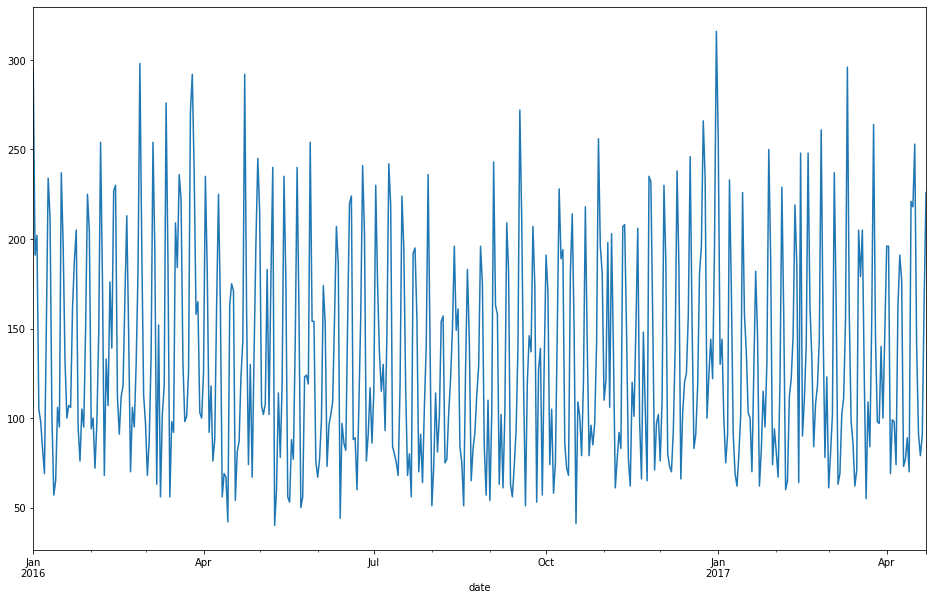

In [11]:
data_1['total'].plot(figsize=(16,10))

In [12]:
data_1.query('holiday==1').index

DatetimeIndex(['2016-01-01', '2016-01-18', '2016-02-02', '2016-02-14',
               '2016-02-15', '2016-03-17', '2016-03-25', '2016-03-27',
               '2016-03-28', '2016-05-05', '2016-05-08', '2016-05-30',
               '2016-06-19', '2016-07-04', '2016-09-05', '2016-10-10',
               '2016-10-31', '2016-11-11', '2016-11-24', '2016-11-25',
               '2016-12-24', '2016-12-25', '2016-12-31', '2017-01-01',
               '2017-01-16', '2017-02-02', '2017-02-14', '2017-02-20',
               '2017-03-17', '2017-04-14', '2017-04-16', '2017-04-17'],
              dtype='datetime64[ns]', name='date', freq=None)

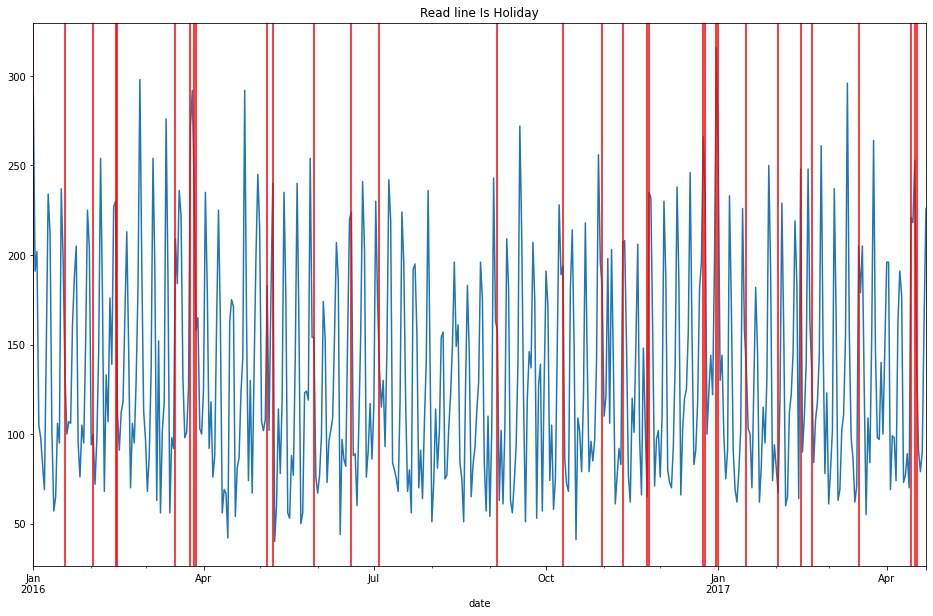

In [13]:
# add vertical line for holiday
ax = data_1['total'].plot(figsize=(16,10), title="Read line Is Holiday")
for day in data_1.query('holiday==1').index:
    ax.axvline(x=day, color='r')

Text(0, 0.5, 'resid')

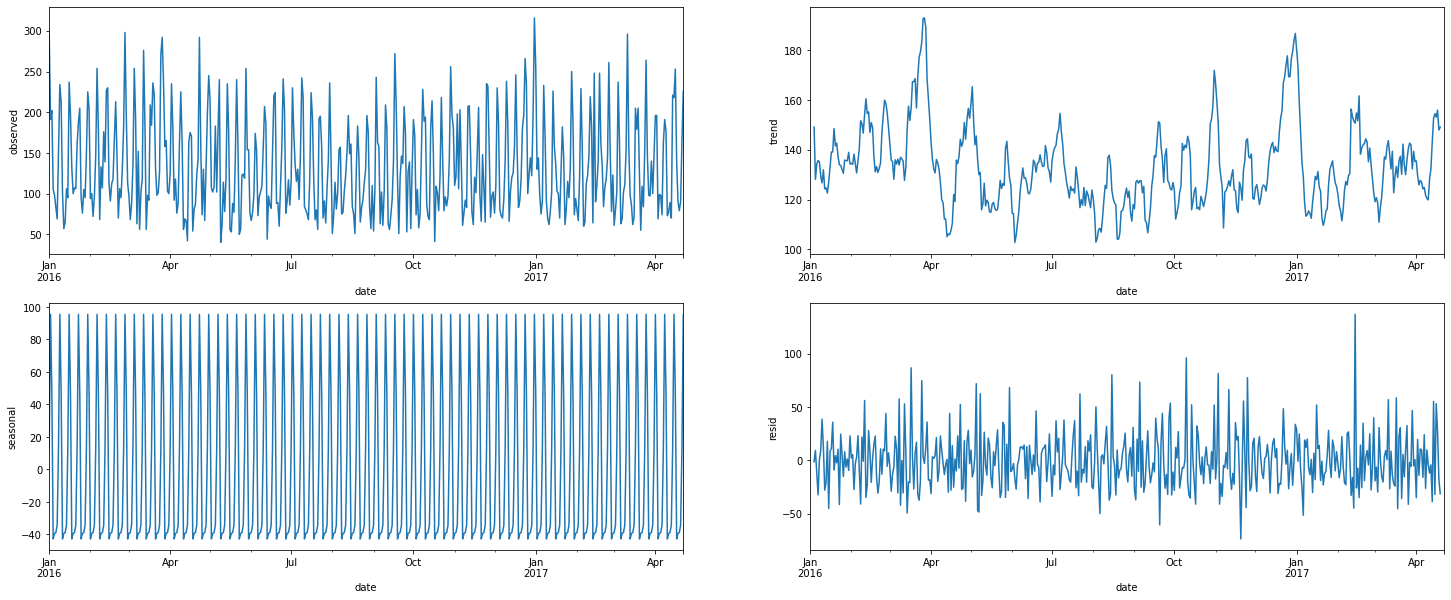

In [14]:
result = seasonal_decompose(data_1['total'])
fig, axe = plt.subplots(2,2,figsize=(25,10))

result.observed.plot(ax=axe[0,0])
axe[0,0].set_ylabel("observed")

result.trend.plot(ax=axe[0,1])
axe[0,1].set_ylabel("trend")

result.seasonal.plot(ax=axe[1,0])
axe[1,0].set_ylabel("seasonal")

result.resid.plot(ax=axe[1,1])
axe[1,1].set_ylabel("resid")

**Sarimax model without x parmaeters**

In [15]:
len(data_1)
train_data = data_1.iloc[:436]
test_data = data_1.iloc[436:]

In [16]:
auto_arima(data_1['total'], seasonal=True, m=7).summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                         y   No. Observations:                  478
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2387.926
Date:                   Tue, 17 Nov 2020   AIC                           4783.852
Time:                           05:25:52   BIC                           4800.531
Sample:                                0   HQIC                          4790.409
                                   - 478                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      6.0699      2.102      2.887      0.004       1.949      10.191
ar.S.L7        0.9534      0.016     60.039      0.000       0.922       0.985
ma.S.L7       -0.7315      0.056    -13.101      0.000      -0.841      -0.622
sigma2      1357.6408     88.981     15.258      0.000    1183.242    1532.040
===================================================================================
Ljung-Box (Q):                       73.59   Jarque-Bera (JB):                58.71
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.73
Prob(H) (two-sided):                  0.33   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
auto_arima(data_1['total'], seasonal=True, m=7)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

ARIMA(maxiter=50, method='lbfgs', order=(0, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 0, 1, 7),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [18]:
# enforce_invertibility=False ValueError: non-invertable MA parameters found
model = SARIMAX(train_data['total'], order=(1,0,0), seasonal_order=(2,0,0,7), enforce_invertibility=False)

In [19]:
result = model.fit()

In [20]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 7)   Log Likelihood               -2224.701
Date:                           Tue, 17 Nov 2020   AIC                           4457.403
Time:                                   05:26:41   BIC                           4473.713
Sample:                               01-01-2016   HQIC                          4463.840
                                    - 03-11-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2212      0.047      4.711      0.000       0.129       0.313
ar.S.L7        0.5063      0.036     14.187      0.000       0.436       0.576
ar.S.L14       0.4574      0.037     12.379      0.000       0.385       0.530
sigma2      1520.2899     82.277     18.478      0.000    1359.029    1681.550
===================================================================================
Ljung-Box (Q):                       83.96   Jarque-Bera (JB):                29.23
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.34
Prob(H) (two-sided):                  0.37   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
start = len(train_data)
end = len(train_data) + len(test_data)-1
prediction = result.predict(start=start, end=end).rename("Sarima model(1, 0, 0)x(2, 0, 0, 7)")

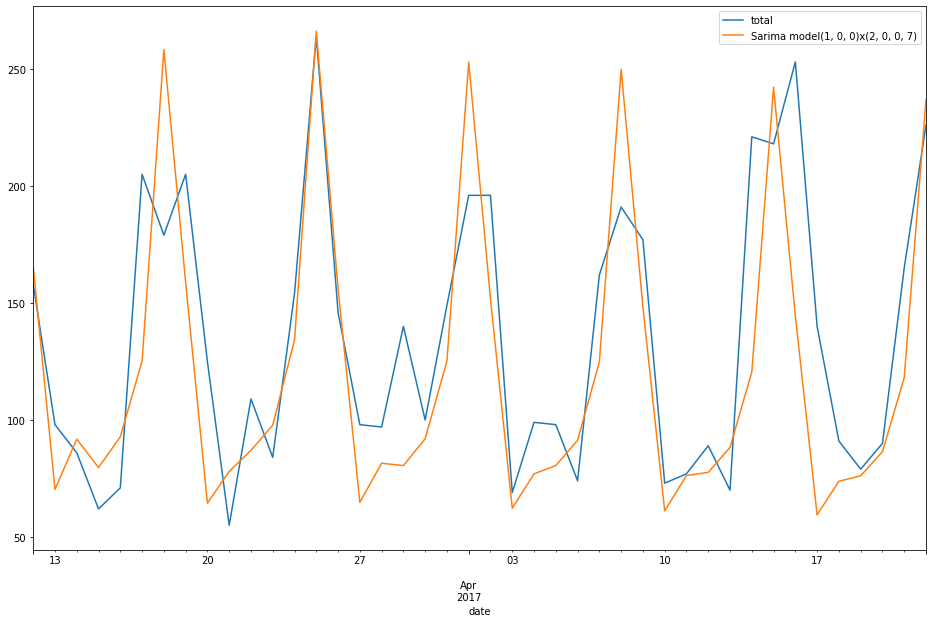

In [22]:
test_data['total'].plot(figsize=(16,10), legend=True)
prediction.plot(legend=True)

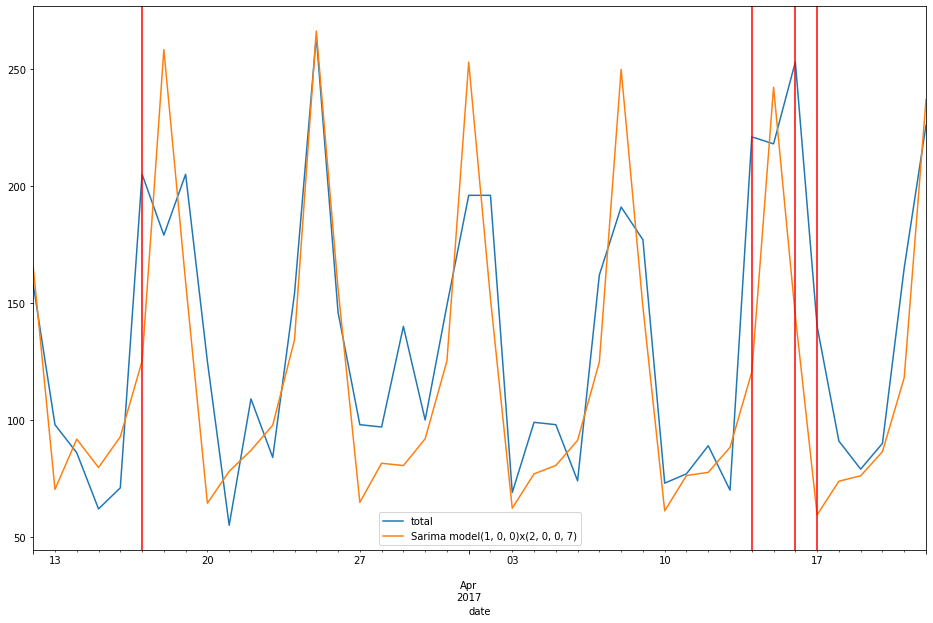

In [23]:
# holiday effect
ax = test_data['total'].plot(figsize=(16,10), legend=True)
prediction.plot(legend=True)
for day in test_data.query('holiday==1').index:
    ax.axvline(x=day, color='r')

In [24]:
# enforce_invertibility=False ValueError: non-invertable MA parameters found
model_1 = SARIMAX(train_data['total'], order=(0,0,0), seasonal_order=(1,0,1,7), enforce_invertibility=False)

In [25]:
result_1 = model_1.fit()

In [26]:
result_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                 
=================================================================================
Dep. Variable:                     total   No. Observations:                  436
Model:             SARIMAX(1, 0, [1], 7)   Log Likelihood               -2165.369
Date:                   Tue, 17 Nov 2020   AIC                           4336.738
Time:                           05:26:43   BIC                           4348.970
Sample:                       01-01-2016   HQIC                          4341.565
                            - 03-11-2017                                         
Covariance Type:                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L7        0.9999   9.57e-05   1.05e+04      0.000       1.000       1.000
ma.S.L7       -0.9384      0.024    -39.208      0.000      -0.985      -0.891
sigma2      1111.8032     58.741     18.927      0.000     996.673    1226.933
===================================================================================
Ljung-Box (Q):                       67.58   Jarque-Bera (JB):                83.57
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.96   Skew:                             0.72
Prob(H) (two-sided):                  0.81   Kurtosis:                         4.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [27]:
prediction_1 = result_1.predict(start=start, end=end).rename("Sarima model(1, 0, [1], 7)")

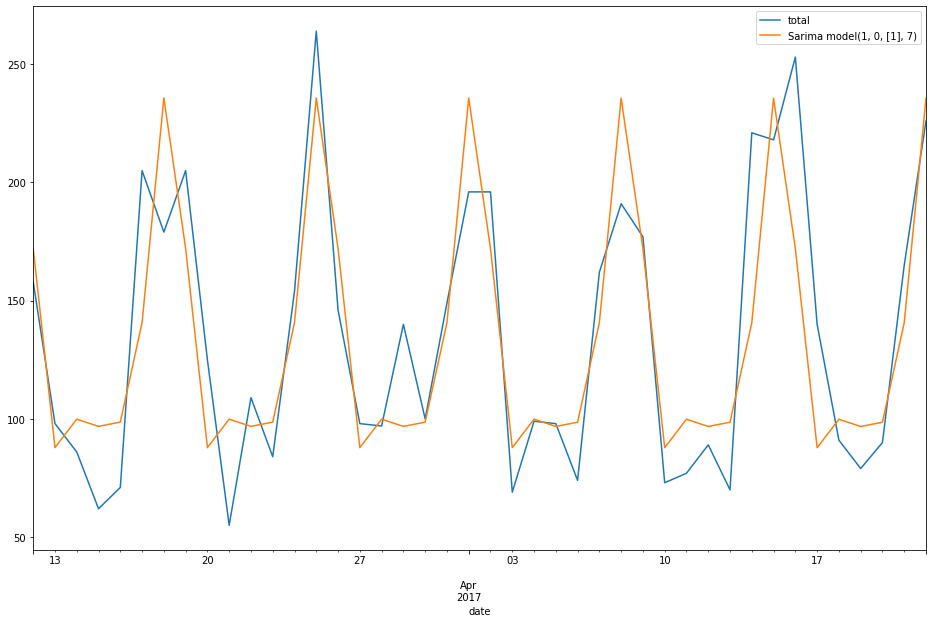

In [28]:
test_data['total'].plot(figsize=(16,10), legend=True)
prediction_1.plot(legend=True)

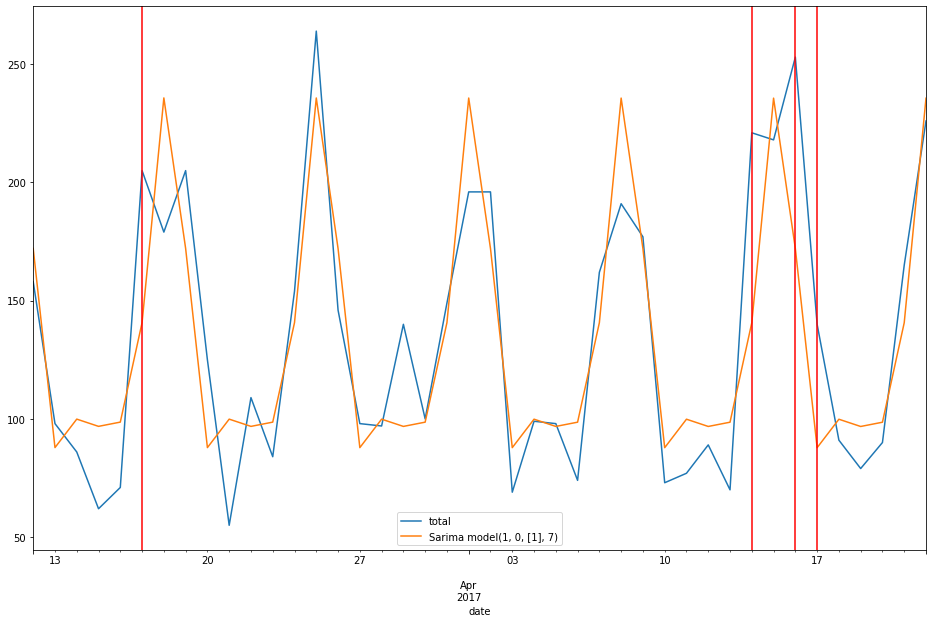

In [29]:
# holiday effect
ax = test_data['total'].plot(figsize=(16,10), legend=True)
prediction_1.plot(legend=True)
for day in test_data.query('holiday==1').index:
    ax.axvline(x=day, color='r')

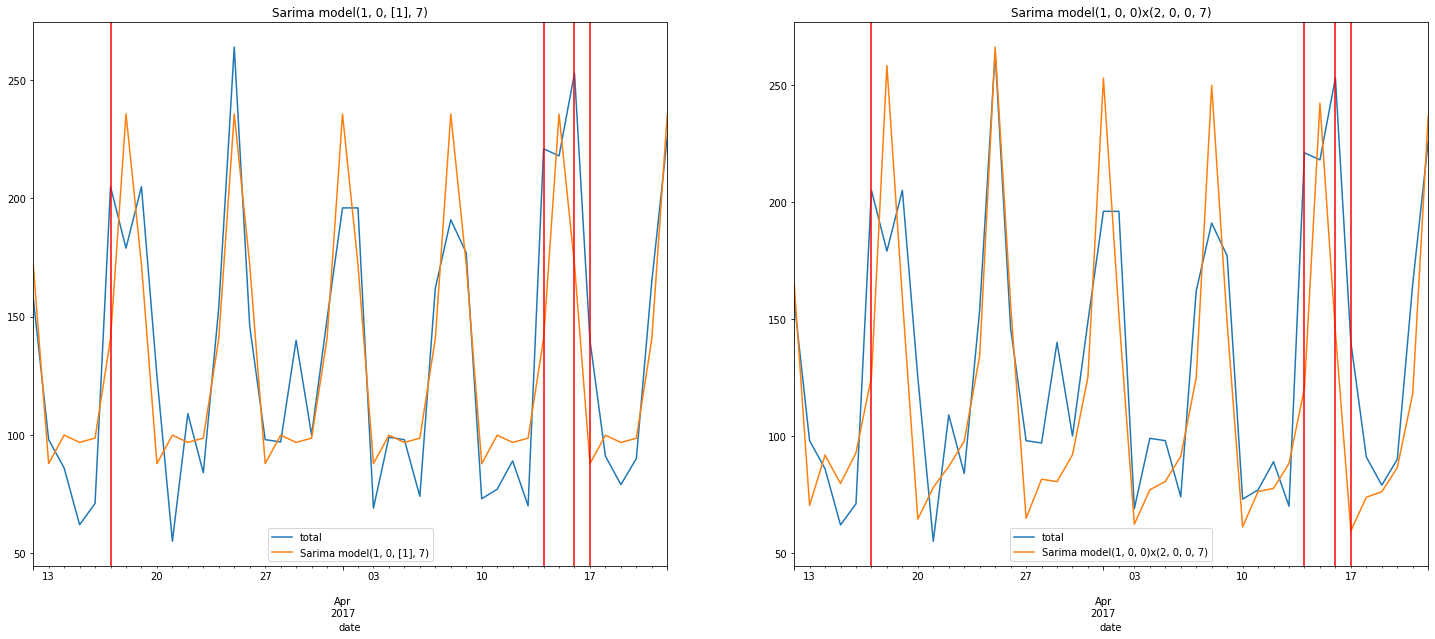

In [30]:
fig, axe = plt.subplots(1,2,figsize=(25,10))
ax = test_data['total'].plot(legend=True, ax=axe[0], title="Sarima model(1, 0, [1], 7)")
prediction_1.plot(legend=True, ax=axe[0])
for day in test_data.query('holiday==1').index:
    ax.axvline(x=day, color='r')

ax = test_data['total'].plot(legend=True, ax=axe[1], title="Sarima model(1, 0, 0)x(2, 0, 0, 7)")
prediction.plot(legend=True, ax=axe[1])
for day in test_data.query('holiday==1').index:
    ax.axvline(x=day, color='r')


**evaluation**

In [31]:
rmse(test_data['total'], prediction)

41.26315491179164

In [32]:
rmse(test_data['total'], prediction_1)

31.912309955204332

In [33]:
test_data['total'].mean()

134.26190476190476

**using exogenous Variable**

In [34]:
# exogenous need data frame not a column
auto_arima(data_1['total'], exogenous=data_1[['holiday']],seasonal=True, m=7)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

ARIMA(maxiter=50, method='lbfgs', order=(1, 0, 0), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(1, 0, 1, 7),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

In [35]:
auto_arima(data_1['total'], exogenous=data_1[['holiday']],seasonal=True, m=7).summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  478
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -2352.074
Date:                             Tue, 17 Nov 2020   AIC                           4716.148
Time:                                     05:28:16   BIC                           4741.166
Sample:                                 01-01-2016   HQIC                          4725.984
                                      - 04-22-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     16.0543      2.850      5.634      0.000      10.469      21.639
holiday       45.9411      4.303     10.676      0.000      37.507      54.375
ar.L1          0.0462      0.046      1.004      0.316      -0.044       0.136
ar.S.L7        0.8725      0.022     40.019      0.000       0.830       0.915
ma.S.L7       -0.4876      0.059     -8.335      0.000      -0.602      -0.373
sigma2      1037.9156     70.910     14.637      0.000     898.934    1176.897
===================================================================================
Ljung-Box (Q):                      115.75   Jarque-Bera (JB):                 8.07
Prob(Q):                              0.00   Prob(JB):                         0.02
Heteroskedasticity (H):               0.89   Skew:                             0.31
Prob(H) (two-sided):                  0.45   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [36]:
model_x = SARIMAX(train_data['total'], exog=train_data[['holiday']], order=(1,0,0), seasonal_order=(1,0,1,7), enforce_invertibility=False)
result_x = model_x.fit()
result_x.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               total   No. Observations:                  436
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -2089.208
Date:                             Tue, 17 Nov 2020   AIC                           4188.417
Time:                                     05:28:17   BIC                           4208.805
Sample:                                 01-01-2016   HQIC                          4196.463
                                      - 03-11-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       68.9347      3.773     18.271      0.000      61.540      76.329
ar.L1          0.2101      0.044      4.763      0.000       0.124       0.297
ar.S.L7        1.0000   5.78e-05   1.73e+04      0.000       1.000       1.000
ma.S.L7       -0.9581      0.022    -43.532      0.000      -1.001      -0.915
sigma2       779.3165     44.867     17.370      0.000     691.379     867.254
===================================================================================
Ljung-Box (Q):                       36.17   Jarque-Bera (JB):                20.47
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.98   Skew:                             0.22
Prob(H) (two-sided):                  0.88   Kurtosis:                         3.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [37]:
start_x= len(train_data)
end_x = len(train_data)+len(test_data)-1

In [38]:
prediction_x = result_x.predict(start=start_x, end=end_x, exog=test_data[['holiday']]).rename("SARIMAX(1, 0, 0)x(1, 0, [1], 7)")

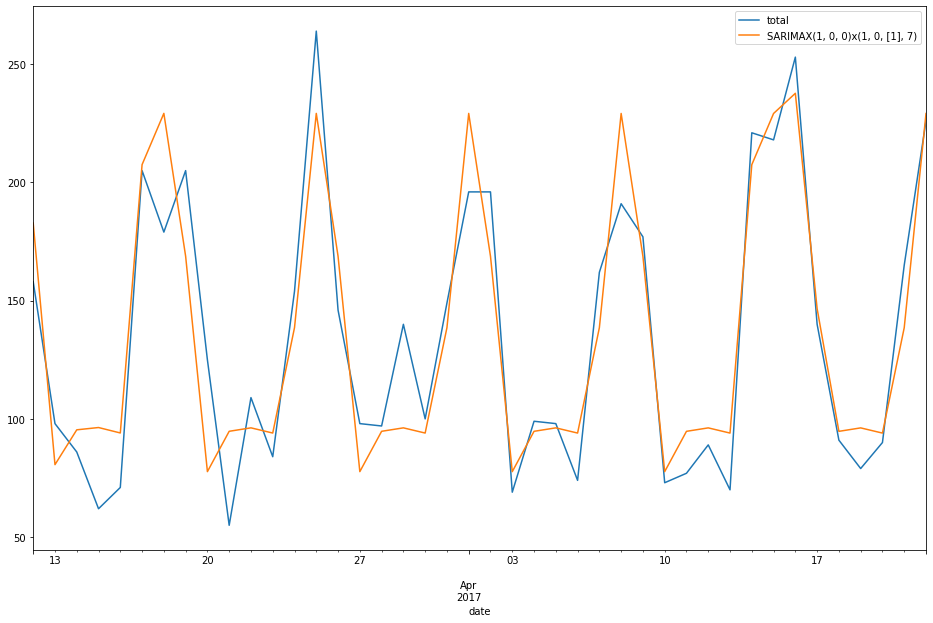

In [39]:
test_data['total'].plot(figsize=(16,10), legend=True)
prediction_x.plot(legend=True, )

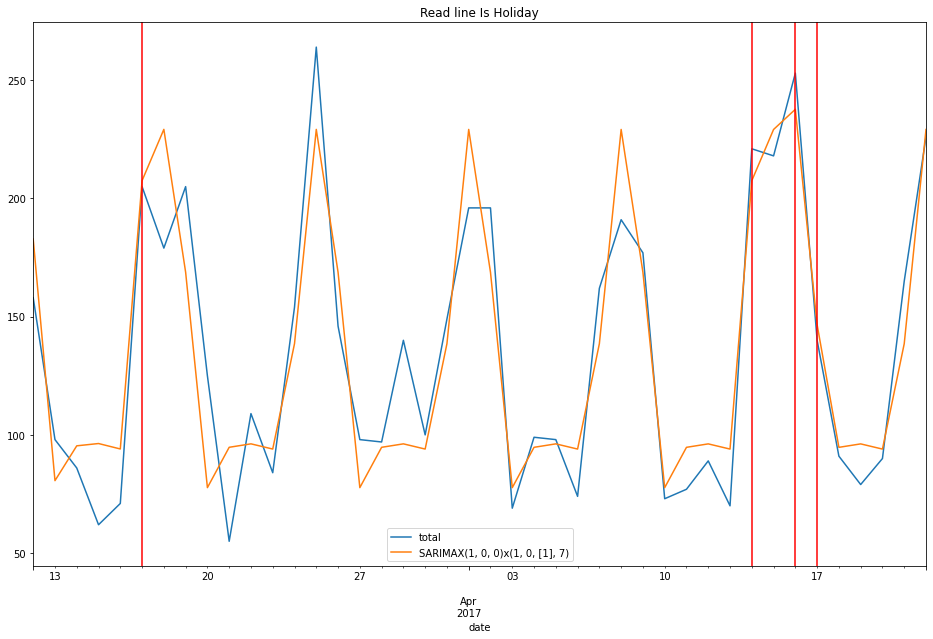

In [40]:
ax = test_data['total'].plot(figsize=(16,10), legend=True, title="Read line Is Holiday")
prediction_x.plot(legend=True, )
for day in test_data.query('holiday==1').index:
    ax.axvline(x=day, color='r')

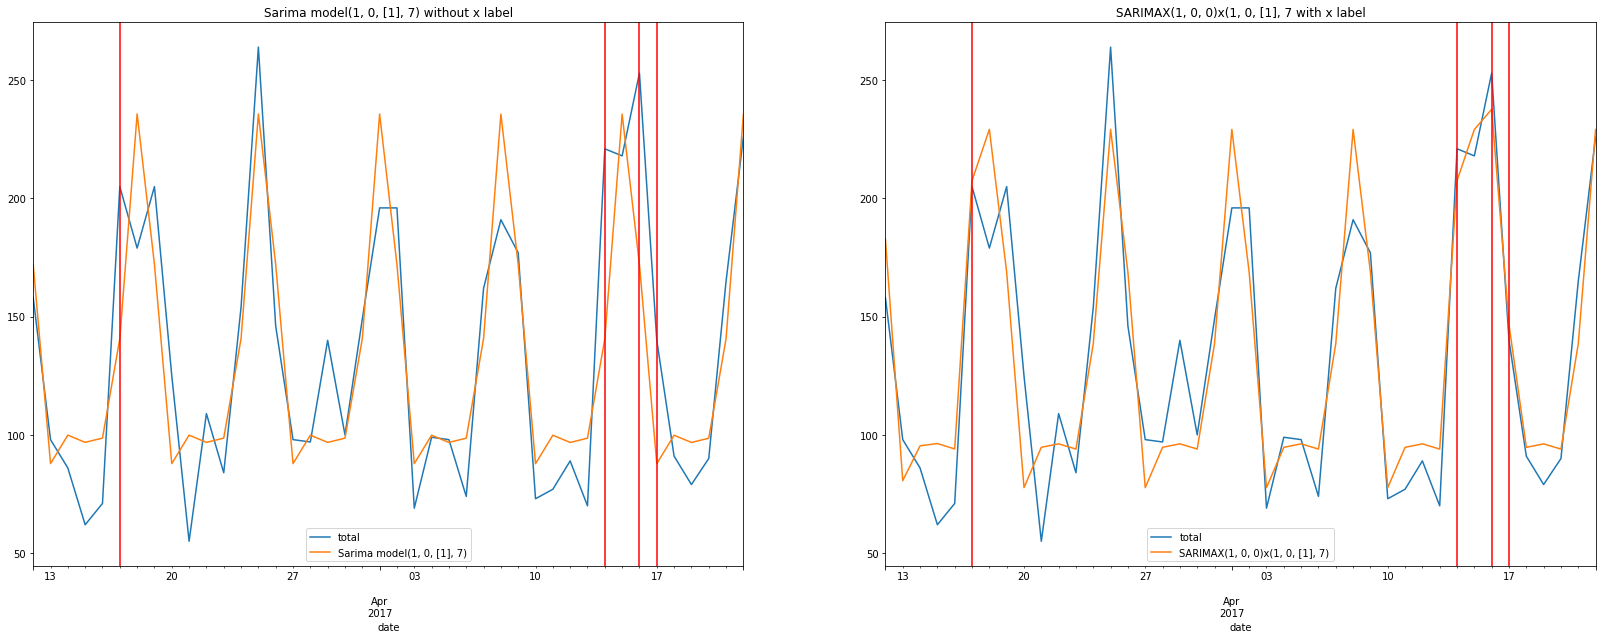

In [41]:
fig, axe = plt.subplots(1,2,figsize=(28,10))
ax = test_data['total'].plot(legend=True, ax=axe[0], title="Sarima model(1, 0, [1], 7) without x label")
prediction_1.plot(legend=True, ax=axe[0])
for day in test_data.query('holiday==1').index:
    ax.axvline(x=day, color='r')

ax = test_data['total'].plot(legend=True, title="SARIMAX(1, 0, 0)x(1, 0, [1], 7 with x label", ax=axe[1])
prediction_x.plot(legend=True, ax=axe[1])
for day in test_data.query('holiday==1').index:
    ax.axvline(x=day, color='r')


In [42]:
rmse(test_data['total'], prediction_x)

22.929760570128547

**Forcast future**

In [43]:
model_final = SARIMAX(data_1['total'], exog=data_1[['holiday']], order=(1,0,0), seasonal_order=(1,0,1,7), enforce_invertibility=False)
result_final = model_final.fit()
result_final.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                               total   No. Observations:                  478
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 7)   Log Likelihood               -2283.572
Date:                             Tue, 17 Nov 2020   AIC                           4577.143
Time:                                     05:28:20   BIC                           4597.992
Sample:                                 01-01-2016   HQIC                          4585.340
                                      - 04-22-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday       69.4435      3.684     18.850      0.000      62.223      76.664
ar.L1          0.1817      0.042      4.312      0.000       0.099       0.264
ar.S.L7        0.9999   8.21e-05   1.22e+04      0.000       1.000       1.000
ma.S.L7       -1.0532      0.023    -45.336      0.000      -1.099      -1.008
sigma2       691.7427     44.401     15.580      0.000     604.719     778.766
===================================================================================
Ljung-Box (Q):                       39.80   Jarque-Bera (JB):                19.75
Prob(Q):                              0.48   Prob(JB):                         0.00
Heteroskedasticity (H):               0.91   Skew:                             0.22
Prob(H) (two-sided):                  0.55   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
data[478:].head()

,weekday,holiday,holiday_name,rest1,rest2,rest3,rest4,total
date,,,,,,,,
2017-04-23,Sunday,0,na,NaN,NaN,NaN,NaN,NaN
2017-04-24,Monday,0,na,NaN,NaN,NaN,NaN,NaN
2017-04-25,Tuesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-04-26,Wednesday,0,na,NaN,NaN,NaN,NaN,NaN
2017-04-27,Thursday,0,na,NaN,NaN,NaN,NaN,NaN


In [45]:
exgo_forcast = data[478:][['holiday']] # no valu after 478
 
forcast = result_final.predict(start=len(data_1), end=len(data_1)+38,exog=exgo_forcast).rename('Final SRIMAX Prediction')

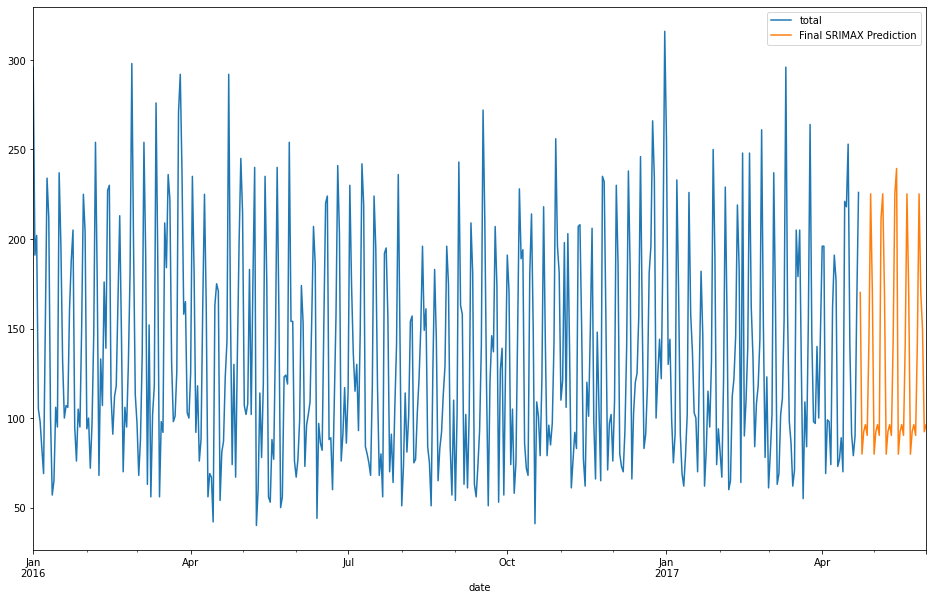

In [46]:
data_1['total'].plot(figsize=(16,10), legend=True)
forcast.plot(legend=True)

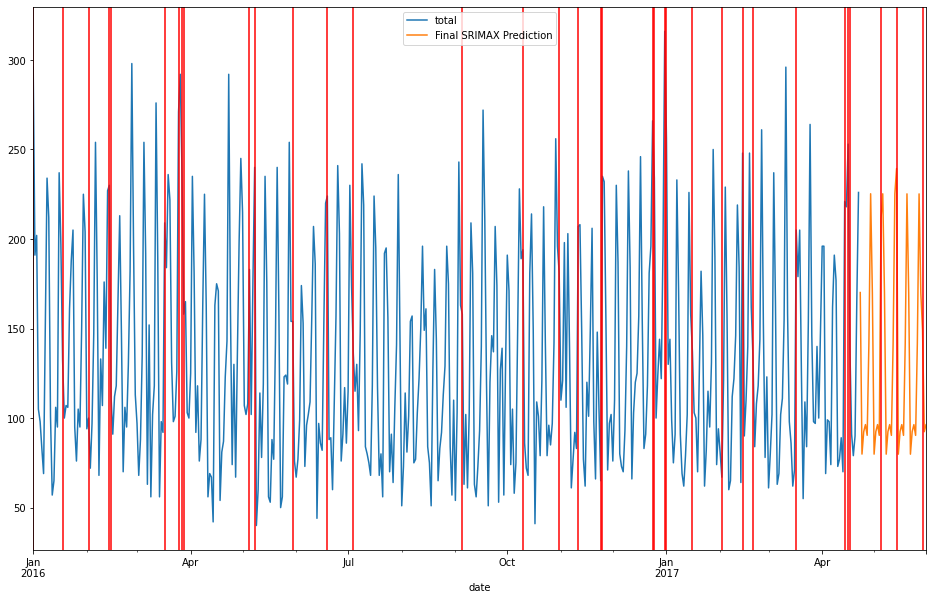

In [47]:
ax = data_1['total'].plot(figsize=(16,10), legend=True)
forcast.plot(legend=True)

# holiday info in primary dataframe "data"
for day in data.query('holiday==1').index:
    ax.axvline(x=day, color='r')

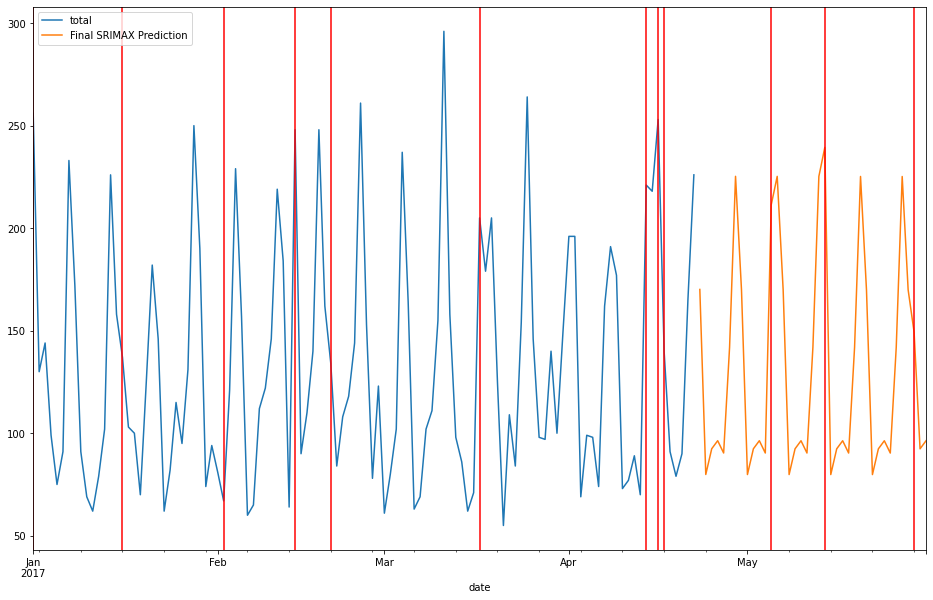

In [53]:
ax = data_1['total'].loc['2017-01-01':].plot(figsize=(16,10), legend=True)
forcast.plot(legend=True)

# holiday info in primary dataframe "data"
for day in data.query('holiday==1').index:
    ax.axvline(x=day, color='r')